# G型フーリエ記述子

## 離散フーリエ変換

輪郭上に等間隔にN+1個の標本点 $P_n$   n=0,1,2, ..., N を取る。ただし、$P_0=P_N$.

$P_n =(x_n,y_n)$ に複素平面上の点 $f_n =　x_n　+ j y_n$ を対応づけ、両者を同一視することにする。

点列 $f_n$   n=0,1,2, ..., N　を周期関数とみなすと、 $f_n　= \frac{1}{N}\sum_{k=0}^{N-1}{F_k exp(j \frac{2 \pi k n}{N}})$ とフーリエ級数展開することができ、

$$F_k=\sum_{n=0}^{N-1}{f_n exp(-j \frac{2 \pi k n}{N}})$$

である。この、$F_i$ をG型フーリエ記述子と呼ぶ。

$F_i$は周期Nの周期関数であり、n=0からN/2までが正の周波数、N/2からNまでが負の周波数に対応し、中央のN/2が最も高い周波数に、０とNが最も低い周波数を表すことに注意が必要である。

## 離散フーリエ逆変換

$F_k$ をフーリエ記述子とするとき、$f_n=\frac{1}{N}\sum_{k=0}^{N-1}{F_n exp(j \frac{2 \pi k n}{N}})$ により、標本点を復元できる。

## numpy の高速フーリエ変換

計算時間を短縮するために、高速フーリエ変換FFTを用いることにする。ここでは詳細は述べないが、FFTはデータ数Nを２のべき乗に限定することで計算量を抑えたアルゴリズムである。

以下の実験ではN＝１２８とした。この場合、フーリエ記述子のインデックス０はバイアス（直流成分）、１から６３まではが正の周波数で数字の順に周波数が上がっていき、６５から１２７までは負の周波数で、数字が増えるにしたがって周波数が下がっていく。

折り返しの６４は正と負両方の最大周波数となる。つまり、１周で６４周期、２ピクセル１周期の波が最大周波数の波形成分となる。（しごく真っ当である）

In [11]:
import numpy as np
import matplotlib
# matplotlib.use('Agg') # 表示しないモード。バッチ処理する場合、画像表示が多くなりすぎて　notebooke の制限で途中で止まってしまう。
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image
import math
import pandas as pd

from sympy import *
from sympy.abc import a,b,c
# init_session()
px,py =var('px:4'),var('py:4')
t = symbols('t')
from sympy import var
from rdlib2 import *

import datetime
import time

import os

# 輪郭データからのひげ除去
def shaver(cnt):  # 輪郭点列のうち、ヒゲ要素を取り除く
    # まず輪郭列のスタート部分がヒゲ要素を取り除く
    while True:
        if len(cnt) > 2 and list(cnt[1][0])==list(cnt[-1][0]): # 最初の点がヒゲの先端
            cnt = cnt[1:-1]
        else:
            break
    # 途中のヒゲ要素を取り除く
    while True:
            l = len(cnt)
            for  i in range(1,len(cnt)-1):
                    if list(cnt[i-1][0]) == list(cnt[i+1][0]):
                            cnt = np.r_[cnt[:i],cnt[i+2:]]
            if l == len(cnt):
                break
    return cnt

# 輪郭に沿った長さ

        
# (x1,y1)から（x2,y2) に向かう直線のX軸に対する角度(0-359)
def getDegree(x1,y1,x2,y2):
        dx = x2-x1
        dy = y2-y1
        if dx == 0 :
            if dy == 0: # 例外
                deg = 0
            elif dy > 0:
                deg = 90
            else:
                deg = 270
        elif dx >0 and dy >= 0:
            deg = 180.0*np.arctan(dy/dx)/np.pi
        elif dx > 0 and dy < 0: 
            deg = 360+180*np.arctan(dy/dx)/np.pi
        else:
            deg =180*(1+ np.arctan(dy/dx)/np.pi)
            # deg = 270.0(1+np.arctan(dy/dx)/np.pi)
        return deg

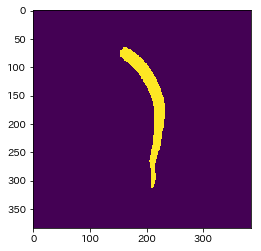

In [136]:
kohaku='シルエット/17Cylindric/17kohaku1o09_l.jpg'
yakumi ='シルエット/17Spheric/17yakumi2o06_l.jpg'
daruma='シルエット/17Apically/17daruma6o06_l.jpg'
aomida='シルエット/17Horn/17aomida1o02_l.jpg'
nezumi='シルエット/17Inv_tri/17nezumi1o06_l.jpg'

kohakuimg = getstandardShape(cv2.imread(kohaku,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  
akumiimg = getstandardShape(cv2.imread(yakumi,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  
darumaimg = getstandardShape(cv2.imread(daruma,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  
aomidaimg = getstandardShape(cv2.imread(aomida,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  
nezumiimg = getstandardShape(cv2.imread(nezumi,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  

#oimg = kohakuimg
oimg = aomidaimg
img = oimg
plt.imshow(oimg)

(205.0, 162.0, (153, 66, 79, 249, 4474))

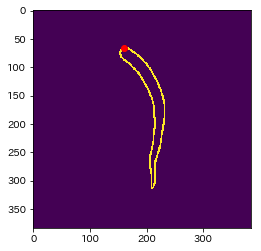

In [137]:
# 輪郭情報
c_x,c_y,(x0,y0,w0,h0,areas) = getCoG(img) # 重心とバウンディングボックスと面積
# img = roteteAndCutMargin(img,130,c_x,c_y)
_image, contours, _hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # 輪郭線追跡
cnt00 = contours[np.argmax([len(c) for c in contours])] # 最も長い輪郭
cnt00 = shaver(cnt00)
canvas = np.zeros_like(img)
canvas = cv2.drawContours(canvas,[cnt00],-1,255,2)
plt.scatter([cnt00[0][0][0]],[cnt00[0][0][1]],color="red")
plt.imshow(canvas)
c_x,c_y,(x0,y0,w0,h0,areas)

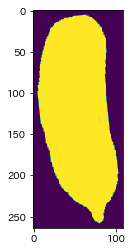

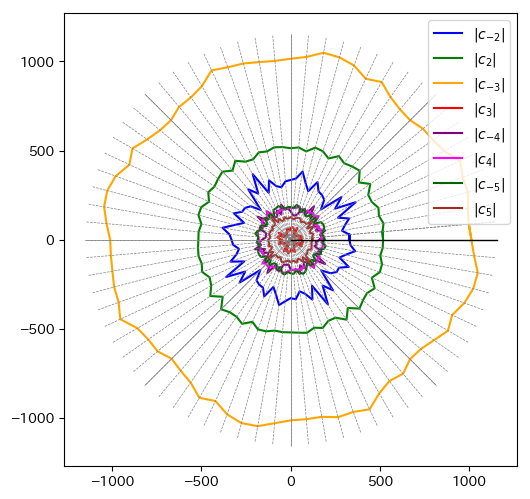

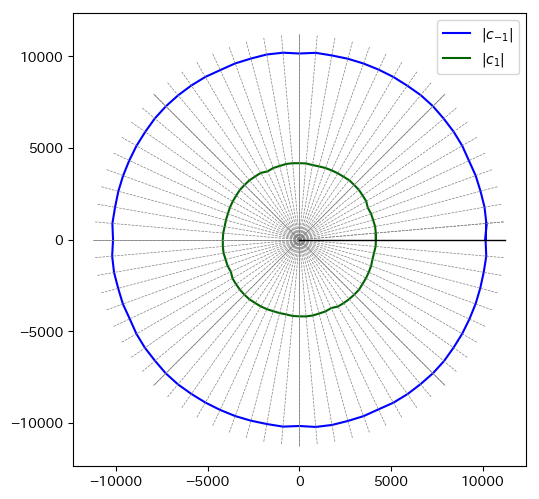

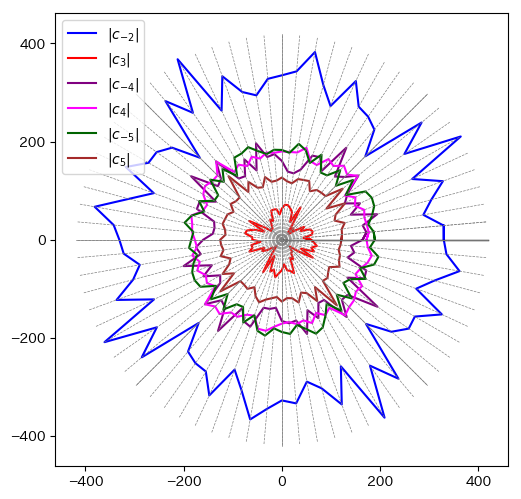

In [142]:
def makefft(angle):
    oimg = kohakuimg
    ### 輪郭情報
    img = roteteAndCutMargin(oimg,angle,c_x,c_y)
    plt.imshow(img)
    _image, contours, _hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # 輪郭線追跡
    cnt00 = contours[np.argmax([len(c) for c in contours])] # 最も長い輪郭
    cnt00 = shaver(cnt00)
    # 重心を中心とした角度の列と輪郭に沿った長さの列 
    lengs = [cv2.arcLength(cnt00[:i+1],False)  for i in range(len(cnt00))]
    # 輪郭点を 128 分割したい
    SPANS = 128
    allLength = cv2.arcLength(cnt00,True) # 輪郭の長さ
    needLengs = np.linspace(0,allLength,SPANS+1)
    s_indexies = []
    index = 0
    for i in range(SPANS):
        nl = needLengs[i]
        for j in range(index,len(cnt00)):
            l0,l1 = lengs[j],lengs[j+1]
            if l0 <= nl and nl <= l1:
                if np.sqrt((l0-nl)**2) < np.sqrt((l1-nl)**2):
                    s_indexies.append(j)
                    index = j+1
                else:
                    s_indexies.append(j+1)
                    index = j+2
                break
    samples =  np.array([[cnt00[i][0][0],cnt00[i][0][1]]  for i  in s_indexies])
    # 複素表現
    # (x,y)と 複素数 x+ jy を同一視する。
    z = [x + y*1j  for [x,y] in samples]
    # フーリエ変換
    F= np.fft.fft(z)
    return F

result = []
for angle in range(0,370,5):
    F = makefft(angle)
    result.append([F[-1],F[1],F[-2],F[2],abs(F[-1]),abs(F[1]),abs(F[-2]),abs(F[2]),abs(F[-3]),abs(F[3]),abs(F[-4]),abs(F[4]),abs(F[-5]),abs(F[5])])

import cmath
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
result = np.array(result)
angles = np.arange(0,370,5)
angles = np.pi*angles/180
cn4x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,4].real)]
cn4y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,4].real)]
cn5x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,5].real)]
cn5y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,5].real)]    
cn6x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,6].real)]
cn6y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,6].real)]
cn7x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,7].real)]
cn7y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,7].real)] 
cn8x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,8].real)]
cn8y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,8].real)]
cn9x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,9].real)]
cn9y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,9].real)] 
cn10x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,10].real)]
cn10y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,10].real)]
cn11x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,11].real)]
cn11y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,11].real)] 
cn12x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,12].real)]
cn12y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,12].real)]
cn13x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,13].real)]
cn13y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,13].real)] 

plt.plot(cn6x,cn6y,color='blue',label='$|c_{-2}|$')
plt.plot(cn7x,cn7y,color='green',label='$|c_2|$')
plt.plot(cn8x,cn8y,color='orange',label='$|c_{-3}|$')
plt.plot(cn9x,cn9y,color='red',label='$|c_3|$')
plt.plot(cn10x,cn10y,color='purple',label='$|c_{-4}|$')
plt.plot(cn11x,cn11y,color='magenta',label='$|c_4|$')
plt.plot(cn12x,cn12y,color='darkgreen',label='$|c_{-5}|$')
plt.plot(cn13x,cn13y,color='brown',label='$|c_5|$')
max = np.max(np.r_[np.abs(np.array(cn8y)),np.abs(np.array(cn8x))])*1.1
for angle in angles:
    plt.plot([0,cmath.rect(max,angle).real],[0,cmath.rect(max,angle).imag],linewidth=0.5,color='gray',linestyle='dashed')
for angle in angles[::9]:
    plt.plot([0,cmath.rect(max,angle).real],[0,cmath.rect(max,angle).imag],linewidth=0.5,color='gray')
plt.plot([0,max],[0,0],linewidth=1,color='black')
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(cn4x,cn4y,color='blue',label='$|c_{-1}|$')
plt.plot(cn5x,cn5y,color='darkgreen',label='$|c_1|$')
max = np.max(np.r_[np.abs(np.array(cn4x)),np.abs(np.array(cn5y))])*1.1
for angle in angles:
    plt.plot([0,cmath.rect(max,angle).real],[0,cmath.rect(max,angle).imag],linewidth=0.5,color='gray',linestyle='dashed')
for angle in angles[::9]:
    plt.plot([0,cmath.rect(max,angle).real],[0,cmath.rect(max,angle).imag],linewidth=0.5,color='gray')
plt.plot([0,max],[0,0],linewidth=1,color='black')
plt.legend()
plt.show()

plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(cn6x,cn6y,color='blue',label='$|c_{-2}|$')
plt.plot(cn9x,cn9y,color='red',label='$|c_3|$')
plt.plot(cn10x,cn10y,color='purple',label='$|c_{-4}|$')
plt.plot(cn11x,cn11y,color='magenta',label='$|c_4|$')
plt.plot(cn12x,cn12y,color='darkgreen',label='$|c_{-5}|$')
plt.plot(cn13x,cn13y,color='brown',label='$|c_5|$')
max = np.max(np.r_[np.abs(np.array(cn6x))])*1.1
for angle in angles:
    plt.plot([0,cmath.rect(max,angle).real],[0,cmath.rect(max,angle).imag],linewidth=0.5,color='gray',linestyle='dashed')
plt.plot([0,max],[0,0],linewidth=1,color='black')
for angle in angles[::9]:
    plt.plot([0,cmath.rect(max,angle).real],[0,cmath.rect(max,angle).imag],linewidth=0.5,color='gray')
plt.legend()
plt.show()
#plt.plot(result[:,1].real,result[:,1].imag,color='blue')
#plt.plot(result[:,2].real,result[:,2].imag,color='orange')
#plt.plot(result[:,3].real,result[:,3].imag,color='green')

(6784+16181j) 17545.581124602286
(-103.57202418992856-10153.344632668894j) 10153.872876589554
(-229.23766634829548-4166.966855121829j) 4173.267626136229
(269.499232988313-190.0739516818801j) 329.78469292745336
(497.0028609768102+146.36315246778435j) 518.1061823790973


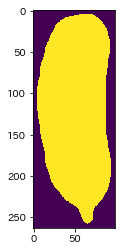

In [143]:
F=makefft(0)
print(F[0],abs(F[0]))
print(F[-1],abs(F[-1]))
print(F[1],abs(F[1]))
print(F[-2],abs(F[-2]))
print(F[2],abs(F[2]))

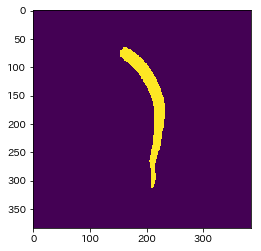

In [144]:
plt.imshow(img)

(205.0, 162.0, (153, 66, 79, 249, 4474))

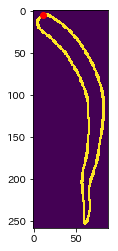

In [145]:
### 輪郭情報
c_x,c_y,(x0,y0,w0,h0,areas) = getCoG(img) # 重心とバウンディングボックスと面積

img = roteteAndCutMargin(img,0,c_x,c_y)

_image, contours, _hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # 輪郭線追跡
cnt00 = contours[np.argmax([len(c) for c in contours])] # 最も長い輪郭
cnt00 = shaver(cnt00)
canvas = np.zeros_like(img)
canvas = cv2.drawContours(canvas,[cnt00],-1,255,2)
plt.scatter([cnt00[0][0][0]],[cnt00[0][0][1]],color="red")
plt.imshow(canvas)
c_x,c_y,(x0,y0,w0,h0,areas)

In [146]:
# 重心を中心とした角度の列と輪郭に沿った長さの列 
angles =  np.array([getDegree(c_x,c_y,x,y) for [[x,y]] in cnt00])  # 重心中心の角度
angles1 =   [angles[0] - (a if a<=angles[0] else a-360) for a in angles] 
lengs = [cv2.arcLength(cnt00[:i+1],False)  for i in range(len(cnt00))]
nangles = 360*np.array(lengs)/lengs[-1]

diff = [[x-c_x,y-c_y] for [[x,y]] in cnt00]
radius = [np.sqrt(dx*dx+dy*dy)  for [dx,dy] in diff]

In [147]:
# 重心中心の極座標表現
# plt.plot(angles1,radius)
# plt.plot(lengs,360*np.array(lengs)/lengs[-1])

## まず、経路長を横軸、X,Yを縦軸に取ったグラフ

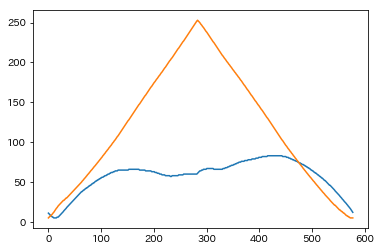

In [148]:
plt.plot(lengs,[x for [[x,y]] in cnt00 ])
plt.plot(lengs,[y for [[x,y]] in cnt00 ])

# サンプリング
点の数が多すぎるので、128点だけサンプリングしてみる

(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 <a list of 8 Text yticklabel objects>)

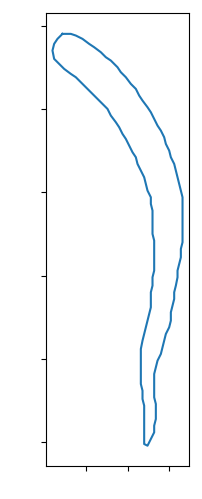

In [149]:
# 輪郭点を 128 分割したい
SPANS = 128
allLength = cv2.arcLength(cnt00,True) # 輪郭の長さ
needLengs = np.linspace(0,allLength,SPANS+1)
s_indexies = []
index = 0
for i in range(SPANS):
    nl = needLengs[i]
    for j in range(index,len(cnt00)):
        l0,l1 = lengs[j],lengs[j+1]
        if l0 <= nl and nl <= l1:
            if np.sqrt((l0-nl)**2) < np.sqrt((l1-nl)**2):
                s_indexies.append(j)
                index = j+1
            else:
                s_indexies.append(j+1)
                index = j+2
            break
samples =  np.array([[cnt00[i][0][0],cnt00[i][0][1]]  for i  in s_indexies])
# 表示して確認
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
#plt.scatter(samples[:,0],samples[:,1] ,marker='.',color="red")
plt.plot(np.r_[samples[:,0],[samples[0][0]]],np.r_[samples[:,1],[samples[0][1]]])
#plt.scatter(samples[0][0],samples[0][1],marker="*")
plt.xticks(color="None")
plt.yticks(color="None")

サンプル点だけでX,Yをプロットして十分かどうか確認

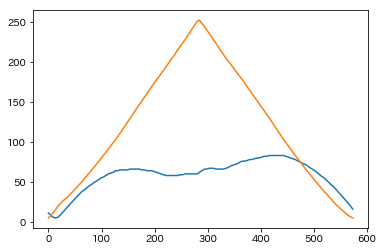

In [150]:
# 128点でプロット
plt.plot([lengs[i] for i in s_indexies],samples[:,0])
plt.plot([lengs[i] for i in s_indexies],samples[:,1])

# フーリエ変換

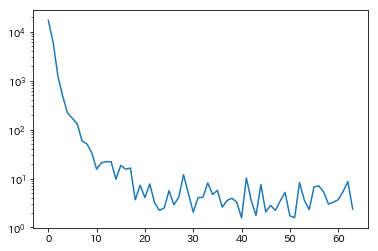

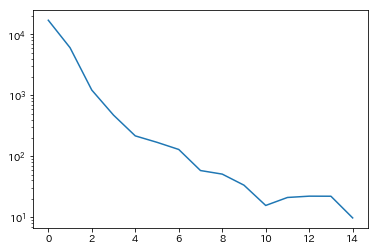

In [151]:
# 複素表現
# (x,y)と 複素数 x+ jy を同一視する。
z = [x + y*1j  for [x,y] in samples]
# フーリエ変換
F= np.fft.fft(z)

# スペクトラム表示
F_abs = np.abs(F)
F_abs_amp = F_abs / SPANS *2 # 交流成分はデータ数で割って2倍
F_abs_amp[0] = F_abs_amp[0] / 2 # 直流成分（今回は扱わないけど）は2倍不要
plt.yscale("log")
fq = np.linspace(0,  int(SPANS/2)-1,  int(SPANS/2))
plt.plot(fq, F_abs[: int(SPANS/2)])
plt.show()
plt.yscale("log")
plt.plot(fq[:15], F_abs[:15])

# フーリエ逆変換

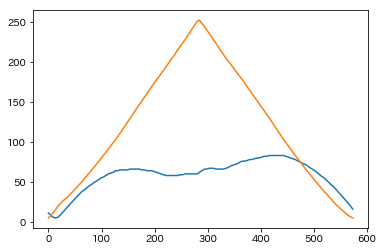

In [152]:
# フーリエ逆変換
F_ifft= np.fft.ifft(F)
plt.plot([lengs[i] for i in s_indexies],F_ifft.real)
plt.plot([lengs[i] for i in s_indexies],F_ifft.imag)

(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 <a list of 8 Text yticklabel objects>)

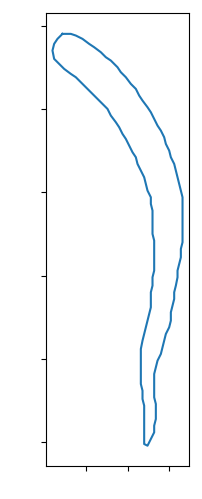

In [153]:
# 復元
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(F_ifft.real,F_ifft.imag)
plt.xticks(color="None")
plt.yticks(color="None")

In [154]:
print(F[0],abs(F[0]))
print(F[-1],abs(F[-1]))
print(F[1],abs(F[1]))
print(F[-2],abs(F[-2]))
print(F[2],abs(F[2]))

(7407+15384j) 17074.281976118353
(-1461.9796391335533-7348.618036848784j) 7492.634484394682
(-760.8118860459225-5996.902219912541j) 6044.970716317881
(-1125.5043437023187+169.74512033025434j) 1138.2325920341236
(-1139.0951106158027+432.07151716215657j) 1218.2871036712306


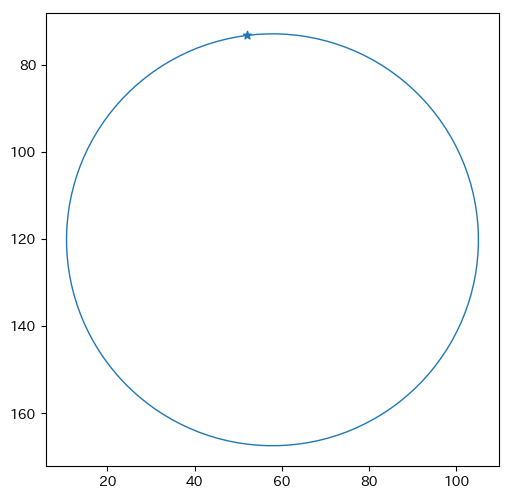

In [155]:
# 指定された項だけで逆変換
def invffttSelect(fd,ks=[0]):
    F_cut = np.zeros_like(fd)
    for i in ks:
        F_cut[i]=fd[i]
    ifft = np.fft.ifft(F_cut)
    ifft = np.r_[ifft,[ifft[0]]]
    
    plt.figure(figsize=(6,6),dpi=100)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().invert_yaxis() 
    plt.scatter(ifft[0].real,ifft[0].imag,marker="*")
    plt.plot(ifft.real,ifft.imag,linewidth = 1)

invffttSelect(fd=F,ks=[0,1])


#  ローパスフィルタ
高周波成分をカット



/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['07YasashisaGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


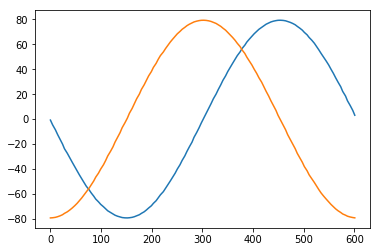

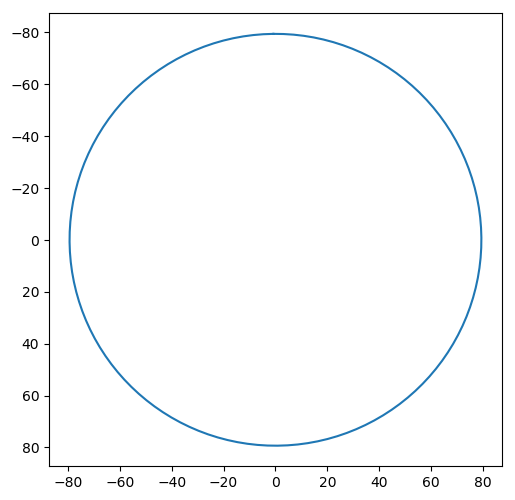

In [62]:
#  ローパスパスフィルタを通してフーリエ逆変換
F_cut = F.copy()
F_cut[0:-1]=0+0j # 0,1 のみ　
F_ifft = np.fft.ifft(F_cut)
plt.plot([lengs[i] for i in s_indexies],F_ifft.real)
plt.plot([lengs[i] for i in s_indexies],F_ifft.imag)

# 復元
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(F_ifft.real,F_ifft.imag)


(array([-100.,  -50.,    0.,   50.,  100.,  150.,  200.,  250.,  300.]),
 <a list of 9 Text yticklabel objects>)

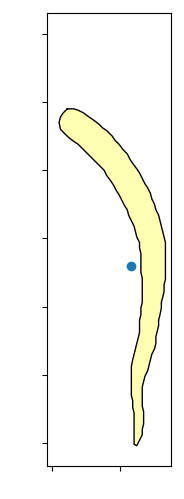

In [156]:
plt.rcParams['font.family'] = 'IPAexGothic' #全体のフォントを設定

#ローパスパスフィルタを通してフーリエ逆変換
F_cut = F.copy()
F_cut[1:]=0+0j # 0,1 ,2 
F_ifft = np.fft.ifft(F_cut)
gx = F_ifft.real[0]
gy = F_ifft.imag[0]

#ローパスパスフィルタを通してフーリエ逆変換
F_cut = F.copy()
F_cut[2:-1]=0+0j # 0,1 ,2 

#F_ifft = np.fft.ifft(F_cut)
#plt.plot([lengs[i] for i in s_indexies],F_ifft.real)
#plt.plot([lengs[i] for i in s_indexies],F_ifft.imag)

# 復元
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(0,-50)
plt.plot(F_ifft.real,F_ifft.imag)

#F_ifft = np.fft.ifft(F_cut)
# 復元
#F_ifft = np.r_[F_ifft,[F_ifft[0]]]
#plt.figure(figsize=(6,6),dpi=100)
#plt.gca().set_aspect('equal', adjustable='box')
#plt.gca().invert_yaxis() 
#plt.plot(F_ifft.real,F_ifft.imag,color="red",label="楕円近似")
# 完全逆変換
# 完全逆変換
F_ifft = np.fft.ifft(F)
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
plt.plot(F_ifft.real,F_ifft.imag,lw=1,alpha=1,color='black',label="輪郭線") 
plt.fill_between( F_ifft.real,F_ifft.imag, facecolor='yellow', alpha=0.3 )
plt.scatter(gx,gy,label="重心")
#plt.legend(loc='upper center') # 凡例を表示
plt.xticks(color="None")
plt.yticks(color="None")

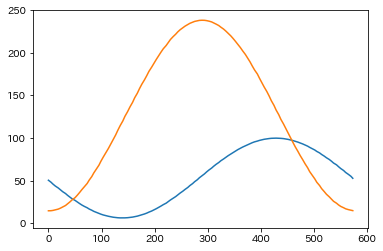

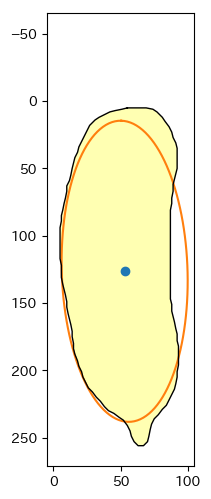

In [133]:
plt.rcParams['font.family'] = 'IPAexGothic' #全体のフォントを設定

#ローパスパスフィルタを通してフーリエ逆変換
F_cut = F.copy()
F_cut[1:]=0+0j # 0,1 ,2 
F_ifft = np.fft.ifft(F_cut)
gx = F_ifft.real[0]
gy = F_ifft.imag[0]

#ローパスパスフィルタを通してフーリエ逆変換
F_cut = F.copy()
F_cut[2:-1]=0+0j # 0,1 ,2 

F_ifft = np.fft.ifft(F_cut)
plt.plot([lengs[i] for i in s_indexies],F_ifft.real)
plt.plot([lengs[i] for i in s_indexies],F_ifft.imag)

# 復元
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(0,-50)
plt.plot(F_ifft.real,F_ifft.imag)

#F_ifft = np.fft.ifft(F_cut)
# 復元
#F_ifft = np.r_[F_ifft,[F_ifft[0]]]
#plt.figure(figsize=(6,6),dpi=100)
#plt.gca().set_aspect('equal', adjustable='box')
#plt.gca().invert_yaxis() 
#plt.plot(F_ifft.real,F_ifft.imag,color="red",label="楕円近似")
# 完全逆変換
# 完全逆変換
F_ifft = np.fft.ifft(F)
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
plt.plot(F_ifft.real,F_ifft.imag,lw=1,alpha=1,color='black',label="輪郭線") 
plt.fill_between( F_ifft.real,F_ifft.imag, facecolor='yellow', alpha=0.3 )
plt.scatter(gx,gy,label="重心")
#plt.legend(loc='upper center') # 凡例を表示

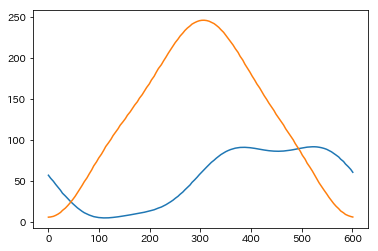

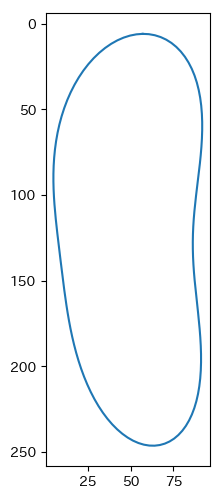

In [77]:
#  ローパスパスフィルタを通してフーリエ逆変換
F_cut = F.copy()
F_cut[ 4:-3]=0+0j # 0,1 ,2、３ 　
F_ifft = np.fft.ifft(F_cut)
plt.plot([lengs[i] for i in s_indexies],F_ifft.real)
plt.plot([lengs[i] for i in s_indexies],F_ifft.imag)

# 復元
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(F_ifft.real,F_ifft.imag)

In [65]:
print(F[0],abs(F[0]))
print(F[-1],abs(F[-1]))
print(F[1],abs(F[1]))
print(F[-2],abs(F[-2]))
print(F[2],abs(F[2]))

(6784+16181j) 17545.581124602286
(-103.57202418992856-10153.344632668894j) 10153.872876589554
(-229.23766634829548-4166.966855121829j) 4173.267626136229
(269.499232988313-190.0739516818801j) 329.78469292745336
(497.0028609768102+146.36315246778435j) 518.1061823790973


/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['07YasashisaGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


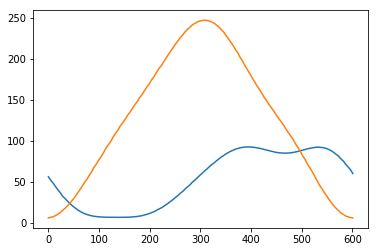

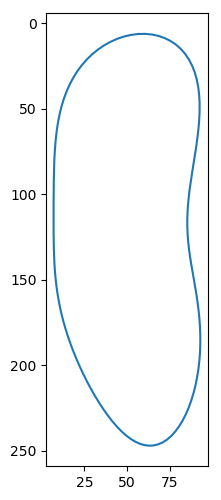

In [66]:
#  ローパスパスフィルタを通してフーリエ逆変換
F_cut = F.copy()
F_cut[5:-4]=0+0j # 0,1 ,2,3 ,4
F_ifft = np.fft.ifft(F_cut)
plt.plot([lengs[i] for i in s_indexies],F_ifft.real)
plt.plot([lengs[i] for i in s_indexies],F_ifft.imag)

# 復元
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(F_ifft.real,F_ifft.imag)

/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['07YasashisaGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


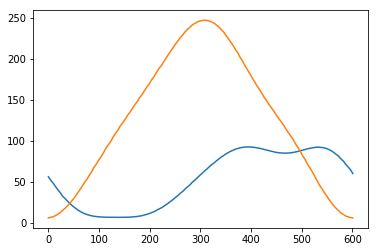

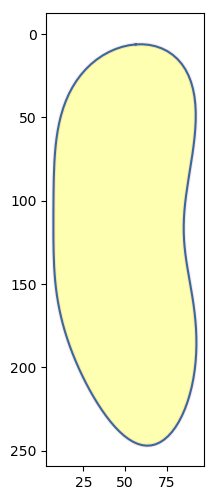

In [67]:
#  ローパスパスフィルタを通してフーリエ逆変換
F_cut = F.copy()
F_cut[5:-4]=0+0j # 0,1 ,2,3 ,4
F_ifft = np.fft.ifft(F_cut)
plt.plot([lengs[i] for i in s_indexies],F_ifft.real)
plt.plot([lengs[i] for i in s_indexies],F_ifft.imag)

# 復元
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(F_ifft.real,F_ifft.imag)
# 完全逆変換
plt.plot(F_ifft.real,F_ifft.imag,lw=3,alpha=0.1,color='red') 
plt.fill_between( F_ifft.real,F_ifft.imag, facecolor='yellow', alpha=0.3 )

/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['07YasashisaGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/mathtext.py:849: MathTextWarning: Font 'default' does not have a glyph for '\u301c' [U+301c]
  MathTextWarning)
/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/mathtext.py:850: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


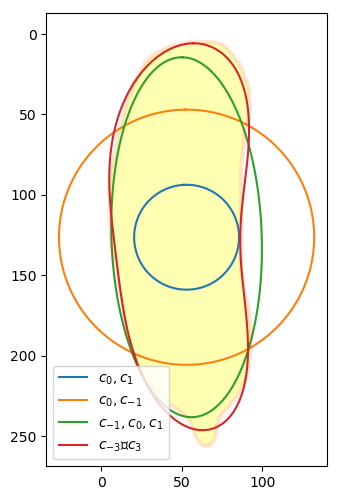

In [35]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.rcParams['font.family'] = '07YasashisaGothic' #全体のフォントを設定
F_cut = F.copy()
F_cut[2:]=0
F_ifft = np.fft.ifft(F_cut)
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
# 復元
plt.plot(F_ifft.real,F_ifft.imag,label="{}".format("$c_0,c_1$"))

F_cut = F.copy()
F_cut[1:-1]=0 
F_ifft = np.fft.ifft(F_cut)
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
# 復元
plt.plot(F_ifft.real,F_ifft.imag,label="{}".format("$c_0,c_{-1}$"))


F_cut = F.copy()
F_cut[2:-1]=0 
F_ifft = np.fft.ifft(F_cut)
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
# 復元
plt.plot(F_ifft.real,F_ifft.imag,label="{}".format("$c_{-1},c_0,c_1$"))


F_cut = F.copy()
F_cut[4:-3]=0 
F_ifft = np.fft.ifft(F_cut)
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
# 復元
plt.rcParams['font.family'] = '07YasashisaGothic' #全体のフォントを設定
plt.plot(F_ifft.real,F_ifft.imag,label="{}〜{}".format("$c_{-3}$","$c_3$"))

# 完全逆変換
F_ifft = np.fft.ifft(F)
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
plt.plot(F_ifft.real,F_ifft.imag,lw=3,alpha=0.1,color='red') 
plt.fill_between( F_ifft.real,F_ifft.imag, facecolor='yellow', alpha=0.3 )
plt.legend() # 凡例を表示

/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['07YasashisaGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


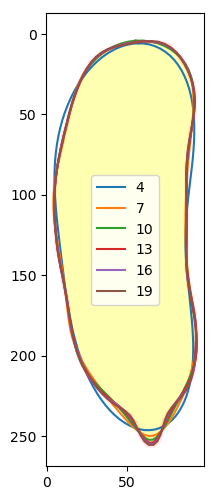

In [36]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(4,20,3):
    F_cut = F.copy()
    F_cut[cutn:1-cutn]=0 
    F_ifft = np.fft.ifft(F_cut)
    F_ifft = np.r_[F_ifft,[F_ifft[0]]]
    # 復元
    plt.plot(F_ifft.real,F_ifft.imag,label="{}".format(cutn))

# 完全逆変換
F_ifft = np.fft.ifft(F)
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
plt.plot(F_ifft.real,F_ifft.imag,lw=3,alpha=0.1,color='red') 
plt.fill_between( F_ifft.real,F_ifft.imag, facecolor='yellow', alpha=0.3 )
plt.legend(loc='center') # 凡例を表示

/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['07YasashisaGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


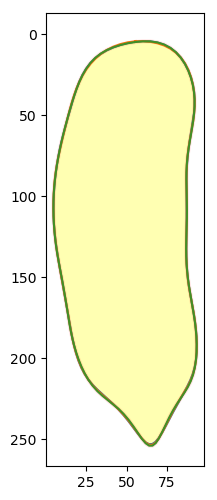

In [37]:
# 11-14項で近似 
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(11,14):
    F_cut = F.copy()
    F_cut[cutn:1-cutn]=0 
    F_ifft = np.fft.ifft(F_cut)
    F_ifft = np.r_[F_ifft,[F_ifft[0]]]
    plt.plot(F_ifft.real,F_ifft.imag)

# 完全逆変換
plt.plot(F_ifft.real,F_ifft.imag,lw=3,alpha=0.1,color='red') 
plt.fill_between( F_ifft.real,F_ifft.imag, facecolor='yellow', alpha=0.3 )

/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['07YasashisaGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


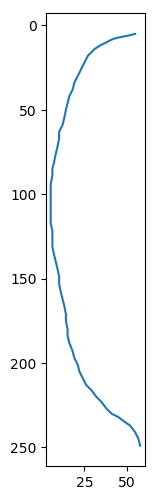

In [45]:
HSPANS=64
# 複素表現
# (x,y)と 複素数 x+ jy を同一視する。
z = [x + y*1j  for [x,y] in samples]
# フーリエ変換
F= np.fft.fft(z[:HSPANS])
# フーリエ逆変換
F_ifft= np.fft.ifft(F)
# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(F_ifft.real,F_ifft.imag)

/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['07YasashisaGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/mathtext.py:849: MathTextWarning: Font 'default' does not have a glyph for '\u301c' [U+301c]
  MathTextWarning)
/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/mathtext.py:850: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


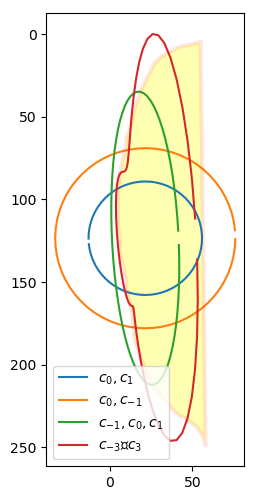

In [43]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.rcParams['font.family'] = '07YasashisaGothic' #全体のフォントを設定
F_cut = F.copy()
F_cut[2:]=0
F_ifft = np.fft.ifft(F_cut)
#F_ifft = np.r_[F_ifft,[F_ifft[0]]]
# 復元
plt.plot(F_ifft.real,F_ifft.imag,label="{}".format("$c_0,c_1$"))

F_cut = F.copy()
F_cut[1:-1]=0 
F_ifft = np.fft.ifft(F_cut)
#F_ifft = np.r_[F_ifft,[F_ifft[0]]]
# 復元
plt.plot(F_ifft.real,F_ifft.imag,label="{}".format("$c_0,c_{-1}$"))


F_cut = F.copy()
F_cut[2:-1]=0 
F_ifft = np.fft.ifft(F_cut)
#F_ifft = np.r_[F_ifft,[F_ifft[0]]]
# 復元
plt.plot(F_ifft.real,F_ifft.imag,label="{}".format("$c_{-1},c_0,c_1$"))


F_cut = F.copy()
F_cut[4:-3]=0 
F_ifft = np.fft.ifft(F_cut)
#F_ifft = np.r_[F_ifft,[F_ifft[0]]]
# 復元
plt.rcParams['font.family'] = '07YasashisaGothic' #全体のフォントを設定
plt.plot(F_ifft.real,F_ifft.imag,label="{}〜{}".format("$c_{-3}$","$c_3$"))

# 完全逆変換
F_ifft = np.fft.ifft(F)
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
plt.plot(F_ifft.real,F_ifft.imag,lw=3,alpha=0.1,color='red') 
plt.fill_between( F_ifft.real,F_ifft.imag, facecolor='yellow', alpha=0.3 )
plt.legend() # 凡例を表示

/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['07YasashisaGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


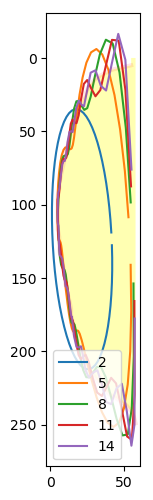

In [44]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(2,15,3):
    F_cut = F.copy()
    F_cut[cutn:1-cutn]=0 
    F_ifft = np.fft.ifft(F_cut)
    # F_ifft = np.r_[F_ifft,[F_ifft[0]]]
    # 復元
    plt.plot(F_ifft.real,F_ifft.imag,label="{}".format(cutn))

# 完全逆変換
F_ifft = np.fft.ifft(F)
# F_ifft = np.r_[F_ifft,[F_ifft[0]]]
plt.plot(F_ifft.real,F_ifft.imag,lw=3,alpha=0.1,color='red') 
plt.fill_between( F_ifft.real,F_ifft.imag, facecolor='yellow', alpha=0.3 )
plt.plot(0,-10)
plt.legend(loc="lower left") # 凡例を表示

/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['07YasashisaGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


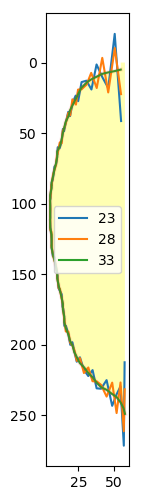

In [41]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(23,34,5):
    F_cut = F.copy()
    F_cut[cutn:1-cutn]=0 
    F_ifft = np.fft.ifft(F_cut)
    # F_ifft = np.r_[F_ifft,[F_ifft[0]]]
    # 復元
    plt.plot(F_ifft.real,F_ifft.imag,label="{}".format(cutn))

# 完全逆変換
F_ifft = np.fft.ifft(F)
# F_ifft = np.r_[F_ifft,[F_ifft[0]]]
plt.plot(F_ifft.real,F_ifft.imag,lw=3,alpha=0.1,color='red') 
plt.fill_between( F_ifft.real,F_ifft.imag, facecolor='yellow', alpha=0.3 )
plt.legend(loc='center') # 凡例を表示

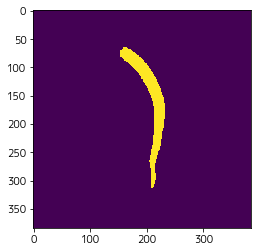

In [79]:
img = aomidaimg
plt.imshow(img)

(205.0, 162.0, (153, 66, 79, 249, 4474))

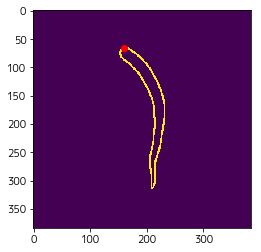

In [54]:
# 輪郭情報
c_x,c_y,(x0,y0,w0,h0,areas) = getCoG(img) # 重心とバウンディングボックスと面積
_image, contours, _hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # 輪郭線追跡
cnt00 = contours[np.argmax([len(c) for c in contours])] # 最も長い輪郭
cnt00 = shaver(cnt00)
canvas = np.zeros_like(img)
canvas = cv2.drawContours(canvas,[cnt00],-1,255,2)
plt.scatter([cnt00[0][0][0]],[cnt00[0][0][1]],color="red")
plt.imshow(canvas)
c_x,c_y,(x0,y0,w0,h0,areas)

In [22]:
# 重心を中心とした角度の列と輪郭に沿った長さの列 
angles =  np.array([getDegree(c_x,c_y,x,y) for [[x,y]] in cnt00])  # 重心中心の角度
angles1 =   [angles[0] - (a if a<=angles[0] else a-360) for a in angles] 
lengs = [cv2.arcLength(cnt00[:i+1],False)  for i in range(len(cnt00))]
nangles = 360*np.array(lengs)/lengs[-1]

diff = [[x-c_x,y-c_y] for [[x,y]] in cnt00]
radius = [np.sqrt(dx*dx+dy*dy)  for [dx,dy] in diff]

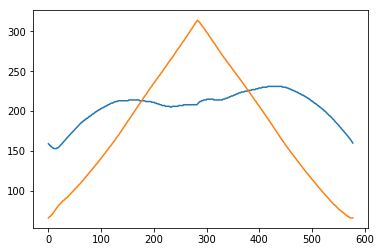

In [23]:
plt.plot(lengs,[x for [[x,y]] in cnt00 ])
plt.plot(lengs,[y for [[x,y]] in cnt00 ])

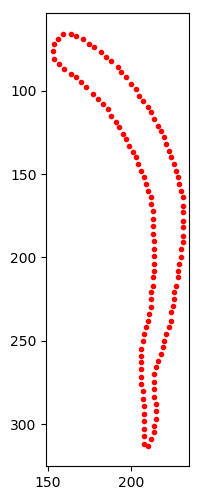

In [24]:
# 輪郭点を 128 分割したい
SPANS = 128
allLength = cv2.arcLength(cnt00,True) # 輪郭の長さ
needLengs = np.linspace(0,allLength,SPANS+1)
# lengs.append(allLength)
# cnt00 = np.r_[cnt00,[cnt00[0]]]
s_indexies = []
index = 0
for i in range(SPANS):
    nl = needLengs[i]
#    for j in range(index,len(cnt00)-1):
    for j in range(index,len(cnt00)):
        l0,l1 = lengs[j],lengs[j+1]
        if l0 <= nl and nl <= l1:
            if np.sqrt((l0-nl)**2) < np.sqrt((l1-nl)**2):
                s_indexies.append(j)
                index = j+1
            else:
                s_indexies.append(j+1)
                index = j+2
            break
samples =  np.array([[cnt00[i][0][0],cnt00[i][0][1]]  for i  in s_indexies])
# 表示して確認
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.scatter(samples[:,0],samples[:,1] ,marker='.',color="red")

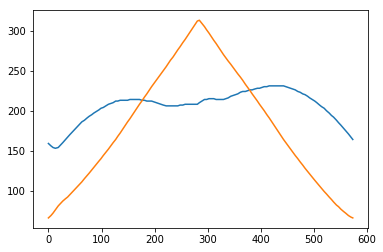

In [25]:
# 128点でX,Yを横軸を経路長としてプロット
plt.plot([lengs[i] for i in s_indexies],samples[:,0])
plt.plot([lengs[i] for i in s_indexies],samples[:,1])

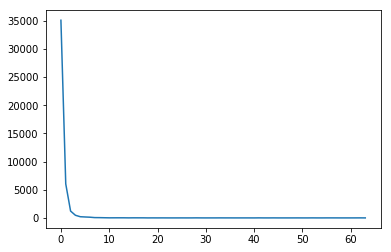

In [26]:
# 複素表現
# (x,y)と 複素数 x+ jy を同一視する。
z = [x + y*1j  for [x,y] in samples]
# フーリエ変換
F= np.fft.fft(z)

# スペクトラム表示
F_abs = np.abs(F)
F_abs_amp = F_abs / SPANS *2 # 交流成分はデータ数で割って2倍
F_abs_amp[0] = F_abs_amp[0] / 2 # 直流成分（今回は扱わないけど）は2倍不要

fq = np.linspace(0,  int(SPANS/2)-1,  int(SPANS/2))
plt.plot(fq, F_abs[: int(SPANS/2)])

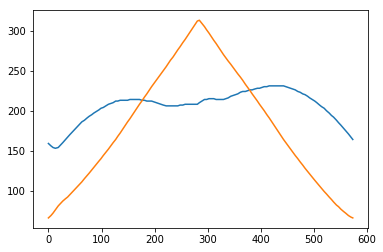

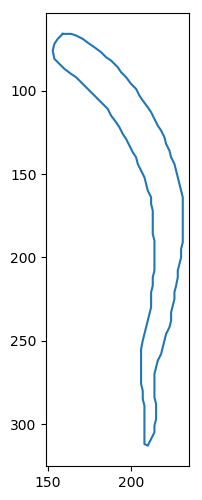

In [27]:
# フーリエ逆変換
F_ifft= np.fft.ifft(F)
plt.plot([lengs[i] for i in s_indexies],F_ifft.real)
plt.plot([lengs[i] for i in s_indexies],F_ifft.imag)
# 復元
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(F_ifft.real,F_ifft.imag)

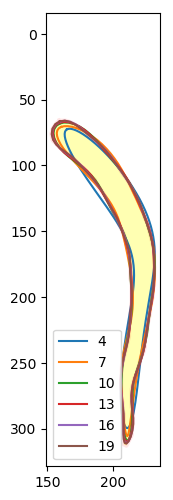

In [28]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(4,20,3):
    F_cut = F.copy()
    F_cut[cutn:1-cutn]=0 
    F_ifft = np.fft.ifft(F_cut)
    F_ifft = np.r_[F_ifft,[F_ifft[0]]]
    plt.plot(F_ifft.real,F_ifft.imag,label="{}".format(cutn))

# 完全逆変換
F_ifft = np.fft.ifft(F)
F_ifft = np.r_[F_ifft,[F_ifft[0]]]
plt.plot(F_ifft.real,F_ifft.imag,lw=3,alpha=0.1,color='red') 
plt.fill_between( F_ifft.real,F_ifft.imag, facecolor='yellow', alpha=0.3 )
plt.legend() # 凡例を表示

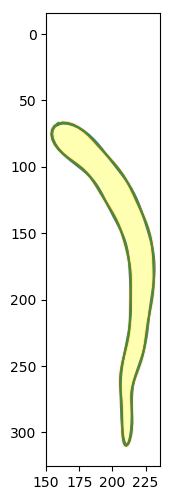

In [29]:
# 11-14項で近似 
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(11,14):
    F_cut = F.copy()
    F_cut[cutn:1-cutn]=0 
    F_ifft = np.fft.ifft(F_cut)
    F_ifft = np.r_[F_ifft,[F_ifft[0]]]
    plt.plot(F_ifft.real,F_ifft.imag)

# 完全逆変換
plt.plot(F_ifft.real,F_ifft.imag,lw=3,alpha=0.1,color='red') 
plt.fill_between( F_ifft.real,F_ifft.imag, facecolor='yellow', alpha=0.3 )

参考

http://www.design.kyushu-u.ac.jp/lib/doctor/1999/k032/k032-03.pdf

http://lbm.ab.a.u-tokyo.ac.jp/~iwata/software/shape_r/shape_r_ppt.pdf

http://www.ic.is.tohoku.ac.jp/~swk/lecture/yaruodsp/dft.html#SECTION00850000000000000000